# Итоговая проектная работа
## Полный анализ датасета 'Students Exam Scores'

In [178]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.diagnostic import linear_harvey_collier
from statsmodels.iolib.summary2 import summary_params
from scipy.stats import t
from scipy.stats import f # F-распределение
from statsmodels.iolib.summary2 import summary_col # вывод подгонки
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
import patsy # матрицы регрессионного дизайна
import scipy.stats as stats
import statsmodels.stats.api as sms # тесты
from scipy.stats import chi2 # 𝜒2-распределение

### 1. Загрузим данные

In [53]:
df = pd.read_csv('/Users/uliana/Downloads/archive/Original_data_with_more_rows.csv')
df

,Unnamed: 0,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore,ReadingScore,WritingScore
0,0,female,group B,bachelor's degree,standard,none,72,72,74
1,1,female,group C,some college,standard,completed,69,90,88
2,2,female,group B,master's degree,standard,none,90,95,93
3,3,male,group A,associate's degree,free/reduced,none,47,57,44
4,4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...,...
30636,995,male,group C,some high school,standard,none,56,47,51
30637,996,male,group E,associate's degree,free/reduced,none,74,75,72
30638,997,male,group C,some college,standard,none,36,29,27
30639,998,male,group A,some high school,free/reduced,completed,43,34,39


###  2. Смотрим на данные, приводим их к нужному виду

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    30641 non-null  int64 
 1   Gender        30641 non-null  object
 2   EthnicGroup   30641 non-null  object
 3   ParentEduc    30641 non-null  object
 4   LunchType     30641 non-null  object
 5   TestPrep      30641 non-null  object
 6   MathScore     30641 non-null  int64 
 7   ReadingScore  30641 non-null  int64 
 8   WritingScore  30641 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 2.1+ MB


Nan-ов нет, удалим неинформативную колонку Unnamed: 0

In [55]:
df = df.drop(labels='Unnamed: 0', axis=1)
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore,ReadingScore,WritingScore
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [56]:
df['Gender'].unique()

array(['female', 'male'], dtype=object)

In [57]:
df['EthnicGroup'].unique()

array(['group B', 'group C', 'group A', 'group D', 'group E'],
      dtype=object)

In [58]:
df['ParentEduc'].unique()

array(["bachelor's degree", 'some college', "master's degree",
       "associate's degree", 'high school', 'some high school'],
      dtype=object)

In [59]:
df['LunchType'].unique()

array(['standard', 'free/reduced'], dtype=object)

In [60]:
df['TestPrep'].unique()

array(['none', 'completed'], dtype=object)

In [61]:
cleanup_nums = {"Gender": {'male': 1, 'female': 0},
               "LunchType": {'standard': 1, 'free/reduced': 0},
               "TestPrep": {'completed': 1, 'none': 0}}
df = df.replace(cleanup_nums)
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore,ReadingScore,WritingScore
0,0,group B,bachelor's degree,1,0,72,72,74
1,0,group C,some college,1,1,69,90,88
2,0,group B,master's degree,1,0,90,95,93
3,1,group A,associate's degree,0,0,47,57,44
4,1,group C,some college,1,0,76,78,75


Категориальные закодируем

In [62]:
area_dummies = pd.get_dummies(df.EthnicGroup)
df = pd.concat([df, area_dummies], axis=1)
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore,ReadingScore,WritingScore,group A,group B,group C,group D,group E
0,0,group B,bachelor's degree,1,0,72,72,74,0,1,0,0,0
1,0,group C,some college,1,1,69,90,88,0,0,1,0,0
2,0,group B,master's degree,1,0,90,95,93,0,1,0,0,0
3,1,group A,associate's degree,0,0,47,57,44,1,0,0,0,0
4,1,group C,some college,1,0,76,78,75,0,0,1,0,0


In [63]:
df = df.rename(columns={"group A": 'A', "group B": 'B', "group C": 'C', "group D": 'D', "group E": 'E'})
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore,ReadingScore,WritingScore,A,B,C,D,E
0,0,group B,bachelor's degree,1,0,72,72,74,0,1,0,0,0
1,0,group C,some college,1,1,69,90,88,0,0,1,0,0
2,0,group B,master's degree,1,0,90,95,93,0,1,0,0,0
3,1,group A,associate's degree,0,0,47,57,44,1,0,0,0,0
4,1,group C,some college,1,0,76,78,75,0,0,1,0,0


In [64]:
cleanup_nums = {"ParentEduc": {'some high school': 'high school'}}
df = df.replace(cleanup_nums)
area_dummies = pd.get_dummies(df.ParentEduc)
df = pd.concat([df, area_dummies], axis=1)
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore,ReadingScore,WritingScore,A,B,C,D,E,associate's degree,bachelor's degree,high school,master's degree,some college
0,0,group B,bachelor's degree,1,0,72,72,74,0,1,0,0,0,0,1,0,0,0
1,0,group C,some college,1,1,69,90,88,0,0,1,0,0,0,0,0,0,1
2,0,group B,master's degree,1,0,90,95,93,0,1,0,0,0,0,0,0,1,0
3,1,group A,associate's degree,0,0,47,57,44,1,0,0,0,0,1,0,0,0,0
4,1,group C,some college,1,0,76,78,75,0,0,1,0,0,0,0,0,0,1


In [66]:
df = df.rename(columns={"associate's degree": 'Assoc', "bachelor's degree": 'Bach', "master's degree": 'Master', "some college": 'College', "high school": 'School'})
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore,ReadingScore,WritingScore,A,B,C,D,E,Assoc,Bach,School,Master,College
0,0,group B,bachelor's degree,1,0,72,72,74,0,1,0,0,0,0,1,0,0,0
1,0,group C,some college,1,1,69,90,88,0,0,1,0,0,0,0,0,0,1
2,0,group B,master's degree,1,0,90,95,93,0,1,0,0,0,0,0,0,1,0
3,1,group A,associate's degree,0,0,47,57,44,1,0,0,0,0,1,0,0,0,0
4,1,group C,some college,1,0,76,78,75,0,0,1,0,0,0,0,0,0,1


Данные готовы к применению моделей!

### 3. Визуализация данных

Числовые признаки

<Axes: xlabel='MathScore', ylabel='Count'>

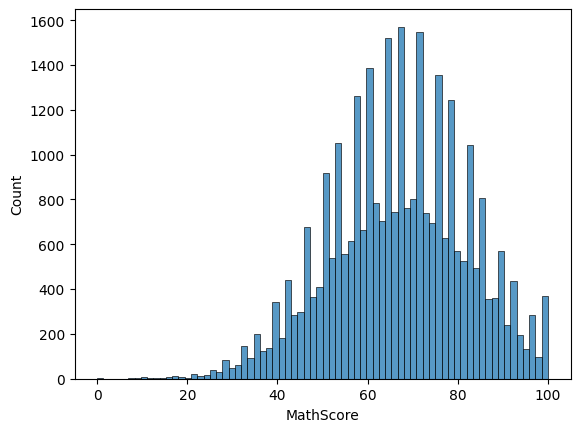

In [68]:
sns.histplot(data=df, x='MathScore')

<Axes: xlabel='ReadingScore', ylabel='Count'>

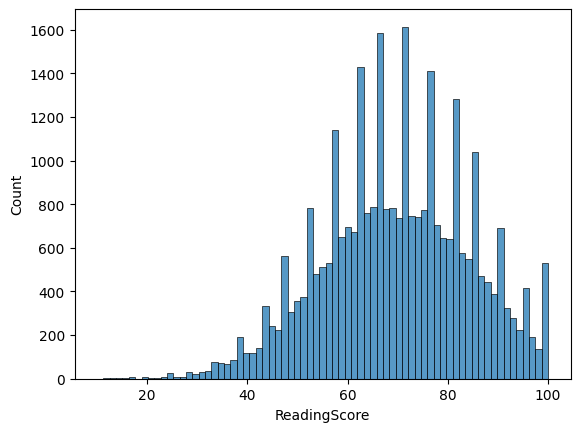

In [69]:
sns.histplot(data=df, x='ReadingScore')

<Axes: xlabel='WritingScore', ylabel='Count'>

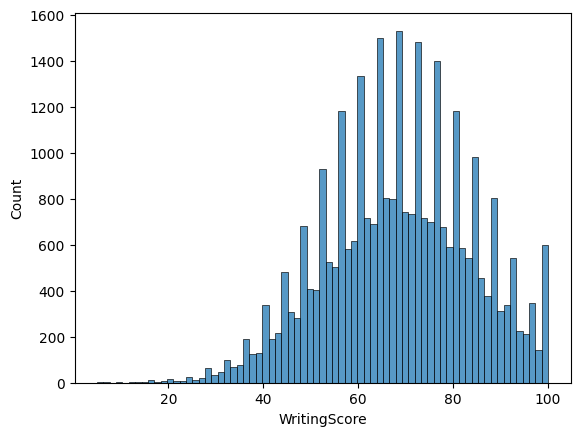

In [74]:
sns.histplot(data=df, x='WritingScore')

Категориальные

<Axes: xlabel='EthnicGroup', ylabel='count'>

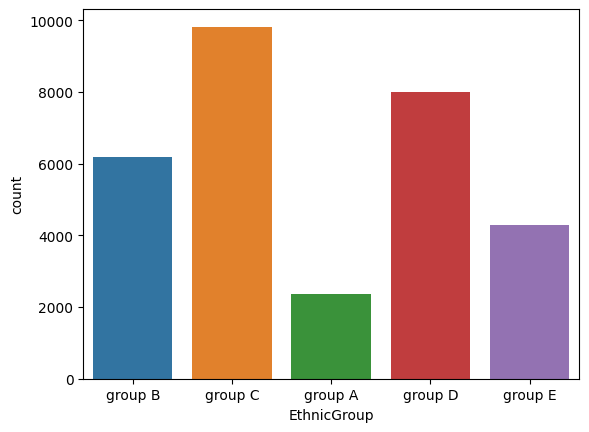

In [76]:
sns.countplot(data=df, x='EthnicGroup')

<Axes: xlabel='ParentEduc', ylabel='count'>

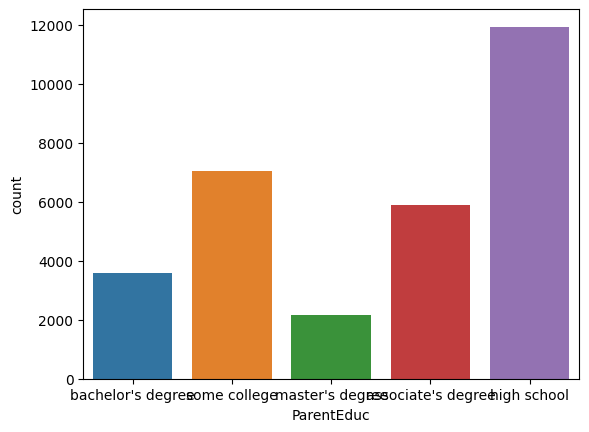

In [77]:
sns.countplot(data=df, x='ParentEduc')

<Axes: xlabel='Gender', ylabel='count'>

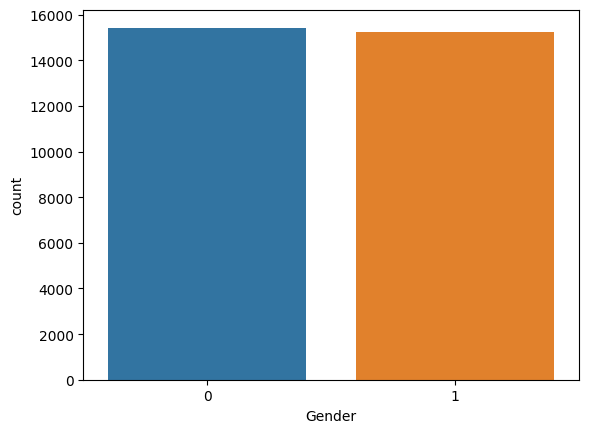

In [78]:
sns.countplot(data=df, x='Gender')

<Axes: xlabel='LunchType', ylabel='count'>

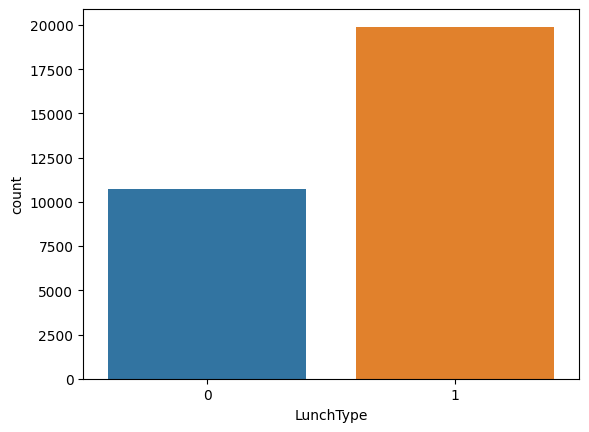

In [79]:
sns.countplot(data=df, x='LunchType')

<Axes: xlabel='TestPrep', ylabel='count'>

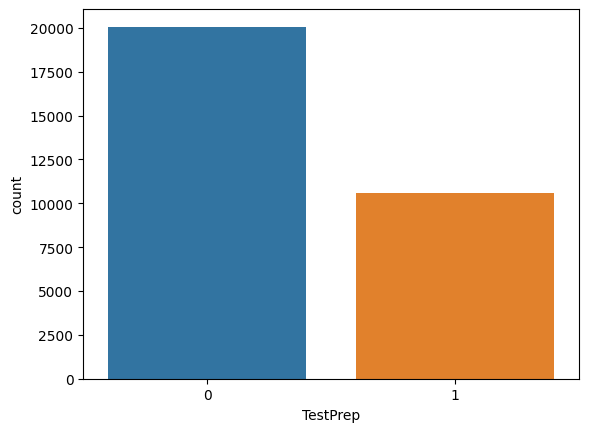

In [80]:
sns.countplot(data=df, x='TestPrep')

Построим несколько графиков для 300 рандомных наблюденйи

<Axes: xlabel='WritingScore', ylabel='MathScore'>

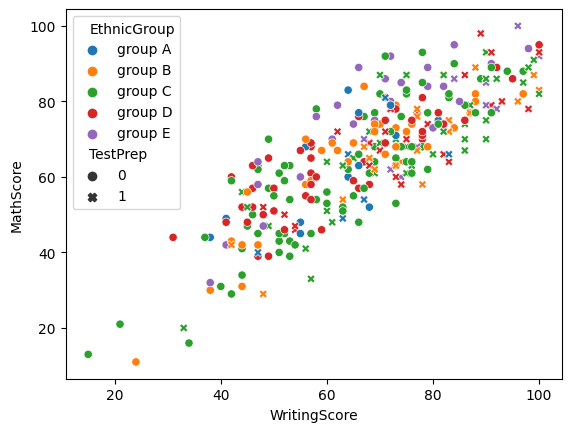

In [93]:
sns.scatterplot(data=df.sample(n = 300), x='WritingScore', y='MathScore', style='TestPrep', hue='EthnicGroup')

<Axes: xlabel='WritingScore', ylabel='MathScore'>

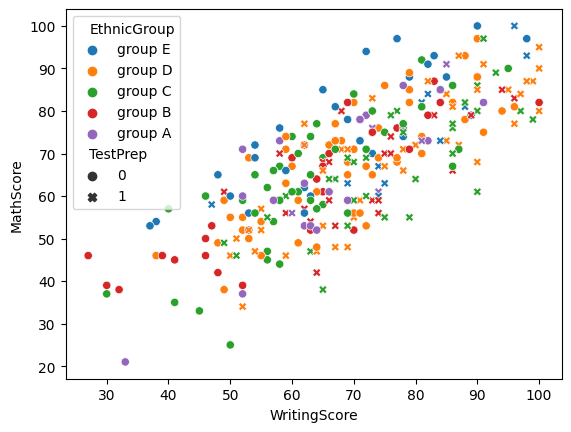

In [94]:
sns.scatterplot(data=df.sample(n = 300), x='WritingScore', y='MathScore', style='TestPrep', hue='EthnicGroup')

<Axes: xlabel='WritingScore', ylabel='MathScore'>

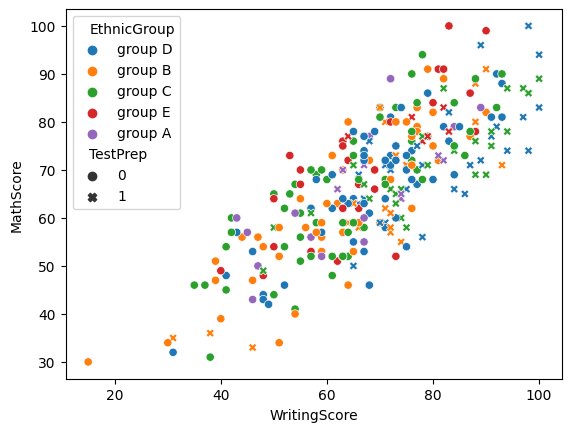

In [95]:
sns.scatterplot(data=df.sample(n = 300), x='WritingScore', y='MathScore', style='TestPrep', hue='EthnicGroup')

Диаграммы рассеения

<Axes: xlabel='WritingScore', ylabel='MathScore'>

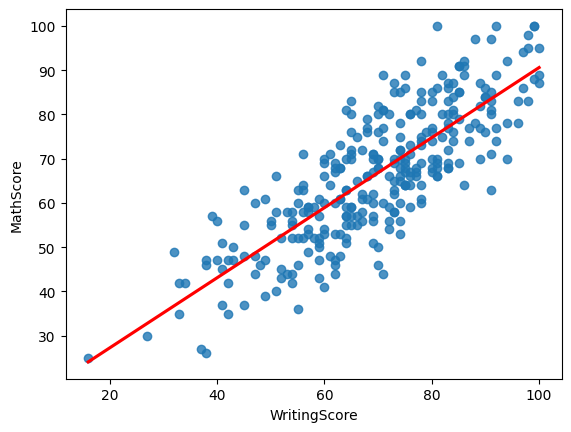

In [97]:
sns.regplot(data=df.sample(n = 300), x='WritingScore', y='MathScore', ci=None, line_kws={"color": "r"})

<Axes: xlabel='WritingScore', ylabel='ReadingScore'>

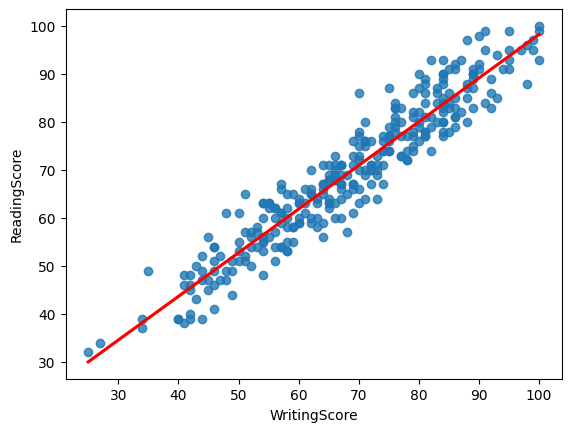

In [99]:
sns.regplot(data=df.sample(n = 300), x='WritingScore', y='ReadingScore', ci=None, line_kws={"color": "r"})

<Axes: xlabel='MathScore', ylabel='ReadingScore'>

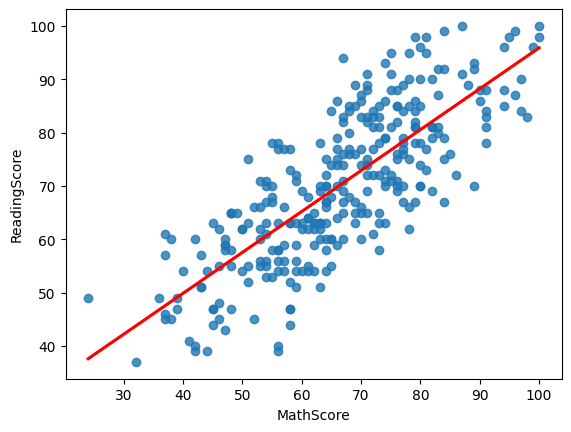

In [100]:
sns.regplot(data=df.sample(n = 300), x='MathScore', y='ReadingScore', ci=None, line_kws={"color": "r"})

### 4 Подгонка модели и спецификация

Будем прогнозировать балл по математике, поэтому берем переменную MathScore за целевую

In [104]:
# специфицируем модель через формулу
math_eq = smf.ols(formula='MathScore~LunchType+Gender+TestPrep+WritingScore+ReadingScore+A+B+C+D+E+Assoc+Bach+School+Master+College', data=df).fit()
# Коэфициенты модели с округление
math_eq.params.round(2)

Intercept       -3.60
LunchType        3.79
Gender          12.86
TestPrep        -3.54
WritingScore     0.69
ReadingScore     0.25
A               -1.84
B               -1.76
C               -1.70
D               -1.90
E                3.60
Assoc           -0.57
Bach            -1.05
School          -0.20
Master          -1.07
College         -0.71
dtype: float64

Спецификация:
    
$MathScore=\beta_0+\beta_1Gender+\beta_2LunchType+\beta_3TestPrep+\beta_4WritingScore+\beta_5ReadingScore+\beta_6A+\beta_7B+\beta_8C+\beta_9D+\beta_{10}E+\beta_{11}Assoc+\beta_{12}Bach+\beta_{13}School+\beta_{14}Master+\beta_{15}College+u$

C подставленными $\beta$:

    
$MathScore=-3.60+12.86*Gender+3.79*LunchType+-3.54*TestPrep+0.69*WritingScore+0.25*ReadingScore+-1.84*A+-1.76*B+-1.70*C+-1.90*D+3.60*E+-0.57*Assoc+-1.05*Bach+-0.20*School+-1.07*Master+-0.71*College$

Интерпретация:
1) С увелечением балла по письму, балл по математике в среднем вырастает на 0.69
2) Мальчики в среднем пишут математику на 12.86 баллоов лучше чем девочки
3) У ученикрв из группы E в среднем на 3.60 балла больше чем у учеников из других групп

### 5. Вычислим коэффиценты детерминации

In [105]:
# R^2
R2 = math_eq.rsquared.round(2)
# adj R^2
R2_adj = math_eq.rsquared_adj.round(2)
print("R^2 =", R2)
print("R^2_adj =", R2_adj)

R^2 = 0.88
R^2_adj = 0.88


### 6. TSS ESS RSS

In [107]:
TSS = math_eq.centered_tss
ESS = math_eq.ess
RSS = math_eq.ssr
print("TSS =", TSS.round(3))
print("ESS =", ESS.round(3))
print("RSS =", RSS.round(3))

TSS = 7084701.05
ESS = 6199581.107
RSS = 885119.942


### 7. Предсказанное значение и остаток для нескольких наблюдений

In [108]:
ind = np.arange(15, 25)
data = pd.DataFrame({'i': ind, 'Факт': df["MathScore"][ind], 'Fitted': math_eq.predict()[ind], 'Остаток': df["MathScore"][ind] - math_eq.predict()[ind]})
data

,i,Факт,Fitted,Остаток
15,15,69,70.476918,-1.476918
16,16,88,92.302529,-4.302529
17,17,18,21.606404,-3.606404
18,18,46,44.968813,1.031187
19,19,54,50.419956,3.580044
20,20,66,71.340925,-5.340925
21,21,65,57.077361,7.922639
22,22,44,60.251573,-16.251573
23,23,69,66.543284,2.456716
24,24,74,75.344717,-1.344717


### 8. Cтандартная ошибка регрессии

In [110]:
n = len(df["MathScore"])
k = 16
s = np.sqrt(RSS / (n - k - 1))
print("s =", s.round(4))

s = 5.3761


### 9. Значимсть коэффицентов регрессии

In [111]:
table = math_eq.summary().tables[1]
df_t = pd.read_html(table.as_html(), header=0, index_col=0)[0] # Эту строку запоминать не нужно
df_t

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.6011,0.126,-28.475,0.0,-3.849,-3.353
LunchType,3.7930,0.068,55.613,0.0,3.659,3.927
Gender,12.8624,0.066,193.810,0.0,12.732,12.992
TestPrep,-3.5442,0.072,-49.514,0.0,-3.684,-3.404
WritingScore,0.6879,0.008,89.899,0.0,0.673,0.703
ReadingScore,0.2472,0.007,33.204,0.0,0.233,0.262
A,-1.8435,0.096,-19.122,0.0,-2.032,-1.655
B,-1.7585,0.066,-26.666,0.0,-1.888,-1.629
C,-1.7022,0.058,-29.549,0.0,-1.815,-1.589
D,-1.8997,0.065,-29.154,0.0,-2.027,-1.772


Вычислим критическое значение для t-теста c уровнем значимости 10%.

In [112]:
alpha = 0.1 # уровень значимости
print('Уровень значимости alpha: ', alpha)
DF = int(math_eq.df_resid) # число степеней свободы 
t_crit = scipy.stats.t.ppf(1-alpha/2, DF)
print('Критическое значение t_crit: ', t_crit.round(3))

Уровень значимости alpha:  0.1
Критическое значение t_crit:  1.645


In [113]:
df_t['znachimosty'] = df_t.apply(lambda x : 'znachim' if np.abs(x['t']) > t_crit else 'ne znachim', axis = 1 )
df_t

,coef,std err,t,P>|t|,[0.025,0.975],znachimosty
Intercept,-3.6011,0.126,-28.475,0.0,-3.849,-3.353,znachim
LunchType,3.7930,0.068,55.613,0.0,3.659,3.927,znachim
Gender,12.8624,0.066,193.810,0.0,12.732,12.992,znachim
TestPrep,-3.5442,0.072,-49.514,0.0,-3.684,-3.404,znachim
WritingScore,0.6879,0.008,89.899,0.0,0.673,0.703,znachim
ReadingScore,0.2472,0.007,33.204,0.0,0.233,0.262,znachim
A,-1.8435,0.096,-19.122,0.0,-2.032,-1.655,znachim
B,-1.7585,0.066,-26.666,0.0,-1.888,-1.629,znachim
C,-1.7022,0.058,-29.549,0.0,-1.815,-1.589,znachim
D,-1.8997,0.065,-29.154,0.0,-2.027,-1.772,znachim


Построим 95% довирительные интервалы для каждого коэффицента

In [114]:
math_eq.conf_int(alpha=0.05)

,0,1
Intercept,-3.849027,-3.353262
LunchType,3.659337,3.926703
Gender,12.732284,12.992445
TestPrep,-3.684493,-3.403892
WritingScore,0.672862,0.702856
ReadingScore,0.232579,0.261760
A,-2.032424,-1.654505
B,-1.887708,-1.629206
C,-1.815111,-1.589293
D,-2.027375,-1.771942


### 10. Значимость регрессии

In [115]:
# Результаты F-теста на значимость регрессии (тестовая статистика и P-значение)
math_eq.fvalue.round(3), math_eq.f_pvalue

(16501.42, 0.0)

In [117]:
# 5%-критическое значение F-распределения
f.ppf(q=1-0.05, dfn=math_eq.df_model, dfd=math_eq.df_resid).round(3)

1.72

**Вывод: ререссия значима**

### 11. Cовместная значимость School, ReadingScore и WritingScore т.е. гипотеза $H_0:\beta_{School}=\beta_{ReadingScore}=\beta_{WritingScore}=0$

In [119]:
print(math_eq.f_test('School=ReadingScore=WritingScore=0'))

<F test: F=49668.05915183964, p=0.0, df_denom=3.06e+04, df_num=3>


In [120]:
f.ppf(q=1-0.05, dfn=3, dfd=math_eq.df_resid)

2.6051991261929865

**Вывод: коэффиценты совместно значимы**

### 12. Протестируем гипотезу о линейных ограничениях $H_0:\beta_{A}+\beta_{B}+\beta_{C}+\beta_{D}+\beta_{E}=-1$

In [139]:
print(math_eq.f_test('A+B+C+D+E=-3'))

<F test: F=22.59421595036734, p=2.0099407176022144e-06, df_denom=3.06e+04, df_num=1>


In [123]:
# критическое значение
f.ppf(q=1-0.05, dfn=1, dfd=math_eq.df_resid)

3.8417624637423082

Вывод: гипотеза отвергается

### 12. Стрктурные сдвиги

Рассмотрим нашу регресси отдельно для Мальчиков $(\beta)$  и Девочек $(\gamma)$

Будем тестировать $H_0:\beta_j=\gamma_j$

Уровеь значимости 1%

In [140]:
specification = 'MathScore~LunchType+Gender+TestPrep+WritingScore+ReadingScore+A+B+C+D+E+Assoc+Bach+School+Master+College'
# подгонка по полному датасету
mod_overall = smf.ols(formula=specification, data=df).fit()
# подгонка только по М
mod_men_only = smf.ols(formula=specification, data=df[df['Gender']==1]).fit()
# подгонка только по Ж
mod_women_only = smf.ols(formula=specification, data=df[df['Gender']==0 ]).fit()
# Вывод трёх регрессий в одной таблице
summary_col(results=[mod_men_only, mod_women_only, mod_overall], stars=True, model_names=['муж', 'жен', 'Общая'],
           info_dict={'N': lambda x: x.nobs, 'F-stat': lambda x: x.fvalue})

,муж,жен,Общая
Intercept,3.5149***,-4.1110***,-3.6011***
,(0.0925),(0.1761),(0.1265)
LunchType,3.8230***,3.7628***,3.7930***
,(0.0966),(0.0963),(0.0682)
Gender,3.5149***,-0.0000***,12.8624***
,(0.0925),(0.0000),(0.0664)
TestPrep,-3.5515***,-3.5396***,-3.5442***
,(0.1019),(0.1005),(0.0716)
WritingScore,0.6788***,0.6971***,0.6879***
,(0.0108),(0.0108),(0.0077)


In [141]:
# Ингредиенты тестовой статистики
print('RSS (overall)=', mod_overall.ssr)
print('RSS (men_only)=', mod_men_only.ssr)
print('RSS (women_only)=', mod_women_only.ssr)
print('n=', mod_overall.nobs)
print('k=', mod_overall.df_model)

RSS (overall)= 885119.9422801668
RSS (men_only)= 436886.9888601297
RSS (women_only)= 447229.44861960097
n= 30641.0
k= 13.0


In [142]:
F = (mod_overall.ssr-mod_men_only.ssr-mod_women_only.ssr)/(mod_men_only.ssr+mod_women_only.ssr)*(mod_overall.nobs-2*(mod_overall.df_model+1))/(mod_overall.df_model+1)
F_cr = f.ppf(q=1-0.01, dfn=mod_overall.df_model+1, dfd=mod_overall.nobs-2*(mod_overall.df_model+1))
F.round(3), F_cr.round(3)

(2.482, 2.082)

**Вывод: струтурные сдвиги значимы**

Грифики

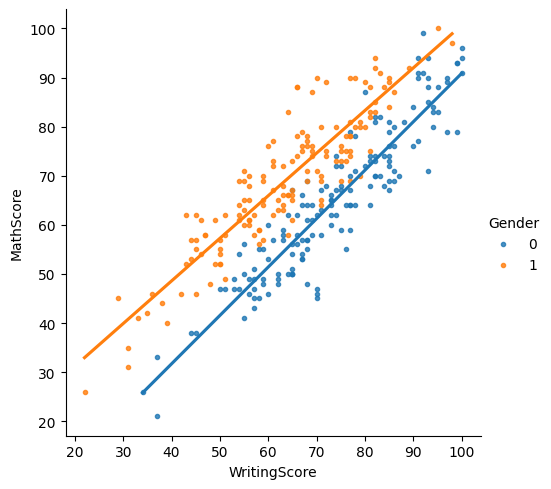

In [146]:
sns.lmplot(data=df.sample(n = 300), x='WritingScore', y='MathScore', hue='Gender', ci=False, markers='.')

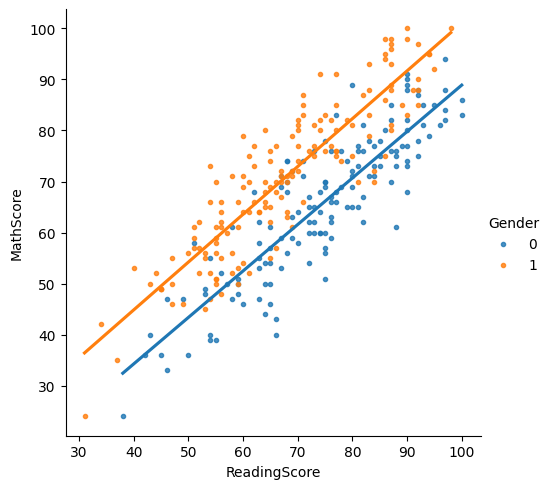

In [148]:
sns.lmplot(data=df.sample(n = 300), x='ReadingScore', y='MathScore', hue='Gender', ci=False, markers='.')

### 13. Прогнозирование для модели регрессии

Рассморим 10 человек

In [154]:
new_df = df.sample(10)
new_df = new_df.drop(labels={'EthnicGroup', 'ParentEduc', 'MathScore'}, axis=1)
new_df

,Gender,LunchType,TestPrep,ReadingScore,WritingScore,A,B,C,D,E,Assoc,Bach,School,Master,College
28989,0,0,0,69,68,0,0,0,1,0,0,0,0,0,1
14870,0,1,0,97,93,0,0,0,1,0,1,0,0,0,0
2272,0,1,1,89,87,0,0,1,0,0,0,0,0,0,1
1869,1,1,0,56,51,0,0,1,0,0,0,0,0,0,1
15043,1,0,0,40,35,1,0,0,0,0,0,0,1,0,0
20222,0,1,0,54,53,1,0,0,0,0,0,0,1,0,0
21760,0,1,0,70,71,0,1,0,0,0,0,0,1,0,0
11507,0,1,0,88,85,0,1,0,0,0,0,0,1,0,0
14404,1,1,0,43,48,0,0,0,1,0,0,0,1,0,0
16949,0,0,0,57,47,0,0,1,0,0,0,0,0,0,1


In [155]:
math_eq.predict(exog=new_df, transform=True)

28989    57.621617
14870    85.666620
2272     76.080612
1869     59.567650
15043    41.176130
20222    47.948620
21760    64.369803
11507    78.448881
14404    54.596631
16949    40.408000
dtype: float64

Непосредственное вычисление $\hat{\beta}_0+\hat{\beta}_1x_1+\cdots+\hat{\beta}_kx_k$ для каждого наблюдения.

В матричном виде $X\hat{\beta}$, где $X$ состоит из значений переменных по столбцам + первый столбец из единиц для учёта $\beta_0$

In [156]:
X = sm.add_constant(new_df)
np.dot(X, math_eq.params)

array([58.06230586, 96.49872201, 86.03133522, 61.77109685, 34.31023152,
       57.45865436, 72.99845806, 88.84029322, 52.39318455, 44.8148931 ])

### 14. Мультиколлинеарность

Какие регрессии нужно рассматривать для вычисления показателей VIF для коэффициентов ReadingScore, Gender, LunchType?


Ответ:


**WritingScore~LunchType+Gender+TestPrep+ReadingScore+A+B+C+D+E+Assoc+Bach+School+Master+College**


**Gender~LunchType+TestPrep+ReadingScore+WritingScore+A+B+C+D+E+Assoc+Bach+School+Master+College**


**LunchType~Gender+TestPrep+ReadingScore+WritingScore+A+B+C+D+E+Assoc+Bach+School+Master+College**

In [157]:
mod1 = smf.ols(formula='WritingScore~LunchType+Gender+TestPrep+ReadingScore+A+B+C+D+E+Assoc+Bach+School+Master+College', data=df).fit()
mod2 = smf.ols(formula='Gender~LunchType+TestPrep+ReadingScore+WritingScore+A+B+C+D+E+Assoc+Bach+School+Master+College', data=df).fit()
mod3 = smf.ols(formula='LunchType~Gender+TestPrep+ReadingScore+WritingScore+A+B+C+D+E+Assoc+Bach+School+Master+College', data=df).fit()
#Результаты подгонки
# info_dict = {'No. Observations': lambda x: '{0:d}'.format(int(x.nobs)), 
#              'R-squared': lambda x: "%#8.3f" % x.rsquared,
#              'Adj. R-squared': lambda x: "%#8.3f" % x.rsquared_adj,
#              'Residual Std. Error': lambda x: "%#8.3f" % x.mse_resid**0.5,
#              'F-statistic': lambda x: '{:.3f}'.format(x.fvalue), 
#              'Prob (F-statistic)': lambda x: '{:.3f}'.format(x.f_pvalue)
#              }

print(summary_col([mod1, mod2, mod3], stars=True, float_format='%.3f'))


               WritingScore   Gender  LunchType
-----------------------------------------------
A              -0.081       0.120***  0.024*** 
               (0.072)      (0.008)   (0.008)  
Assoc          0.335***     0.166***  -0.024***
               (0.052)      (0.006)   (0.006)  
B              0.037        0.126***  0.002    
               (0.049)      (0.006)   (0.006)  
Bach           1.491***     0.218***  -0.060***
               (0.063)      (0.007)   (0.007)  
C              0.116***     0.145***  -0.005   
               (0.043)      (0.005)   (0.005)  
College        0.202***     0.129***  0.013**  
               (0.048)      (0.005)   (0.005)  
D              2.170***     0.230***  -0.062***
               (0.047)      (0.005)   (0.005)  
E              0.436***     0.205***  -0.072***
               (0.061)      (0.007)   (0.007)  
Gender         -2.466***              0.114*** 
               (0.048)                (0.006)  
Intercept      2.677***     0.825***  -

In [158]:
VIF_1 = 1/(1 - mod1.rsquared)
VIF_1.round(2)

14.54

In [159]:
VIF_2 = 1/(1 - mod2.rsquared)
VIF_2.round(2)

1.17

In [160]:
VIF_1 = 1/(1 - mod3.rsquared)
VIF_1.round(2)

1.12

Корреляции между регрессорами

In [161]:
summary_params(math_eq)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,-3.601145,0.126468,-28.474756,4.756709e-176,-3.849027,-3.353262
LunchType,3.793020,0.068204,55.612762,0.000000e+00,3.659337,3.926703
Gender,12.862365,0.066366,193.809583,0.000000e+00,12.732284,12.992445
TestPrep,-3.544193,0.071580,-49.513534,0.000000e+00,-3.684493,-3.403892
WritingScore,0.687859,0.007652,89.898502,0.000000e+00,0.672862,0.702856
ReadingScore,0.247170,0.007444,33.203564,1.571827e-237,0.232579,0.261760
A,-1.843465,0.096406,-19.121916,4.927719e-81,-2.032424,-1.654505
B,-1.758457,0.065943,-26.666395,6.807388e-155,-1.887708,-1.629206
C,-1.702202,0.057606,-29.549261,3.057891e-189,-1.815111,-1.589293
D,-1.899658,0.065160,-29.153710,2.484909e-184,-2.027375,-1.771942


In [162]:
# Матрицы регрессионного дизайна
y, X = patsy.dmatrices(specification, df, return_type='dataframe')
X.head()

,Intercept,LunchType,Gender,TestPrep,WritingScore,ReadingScore,A,B,C,D,E,Assoc,Bach,School,Master,College
0,1.0,1.0,0.0,0.0,74.0,72.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,1.0,0.0,1.0,88.0,90.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1.0,0.0,0.0,93.0,95.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,44.0,57.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,75.0,78.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [163]:
# Удалим первый столбец с единицами
# X.drop(labels='Intercept', axis=1)
# Корреляционная матрицы для регрессоров
X.drop(labels='Intercept', axis=1).corr().round(3)

,LunchType,Gender,TestPrep,WritingScore,ReadingScore,A,B,C,D,E,Assoc,Bach,School,Master,College
LunchType,1.000,-0.002,-0.000,0.277,0.260,0.006,-0.006,0.001,0.003,-0.003,-0.007,-0.001,0.005,-0.011,0.009
Gender,-0.002,1.000,-0.006,-0.291,-0.238,-0.001,-0.006,0.003,0.003,-0.001,0.006,0.002,0.002,-0.001,-0.010
TestPrep,-0.000,-0.006,1.000,0.297,0.215,-0.007,0.011,0.001,-0.007,-0.000,-0.001,0.001,-0.004,-0.005,0.008
WritingScore,0.277,-0.291,0.297,1.000,0.953,-0.061,-0.082,-0.065,0.092,0.112,0.061,0.118,-0.197,0.122,0.007
ReadingScore,0.260,-0.238,0.215,0.953,1.000,-0.053,-0.070,-0.045,0.038,0.134,0.058,0.093,-0.160,0.105,-0.004
A,0.006,-0.001,-0.007,-0.061,-0.053,1.000,-0.145,-0.198,-0.171,-0.116,0.003,0.005,0.003,-0.012,-0.003
B,-0.006,-0.006,0.011,-0.082,-0.070,-0.145,1.000,-0.346,-0.299,-0.203,0.001,-0.012,0.010,0.006,-0.007
C,0.001,0.003,0.001,-0.065,-0.045,-0.198,-0.346,1.000,-0.408,-0.277,0.000,0.001,-0.000,0.004,-0.003
D,0.003,0.003,-0.007,0.092,0.038,-0.171,-0.299,-0.408,1.000,-0.239,-0.003,0.005,-0.008,0.001,0.008
E,-0.003,-0.001,-0.000,0.112,0.134,-0.116,-0.203,-0.277,-0.239,1.000,0.000,0.003,-0.003,-0.005,0.005


<Axes: >

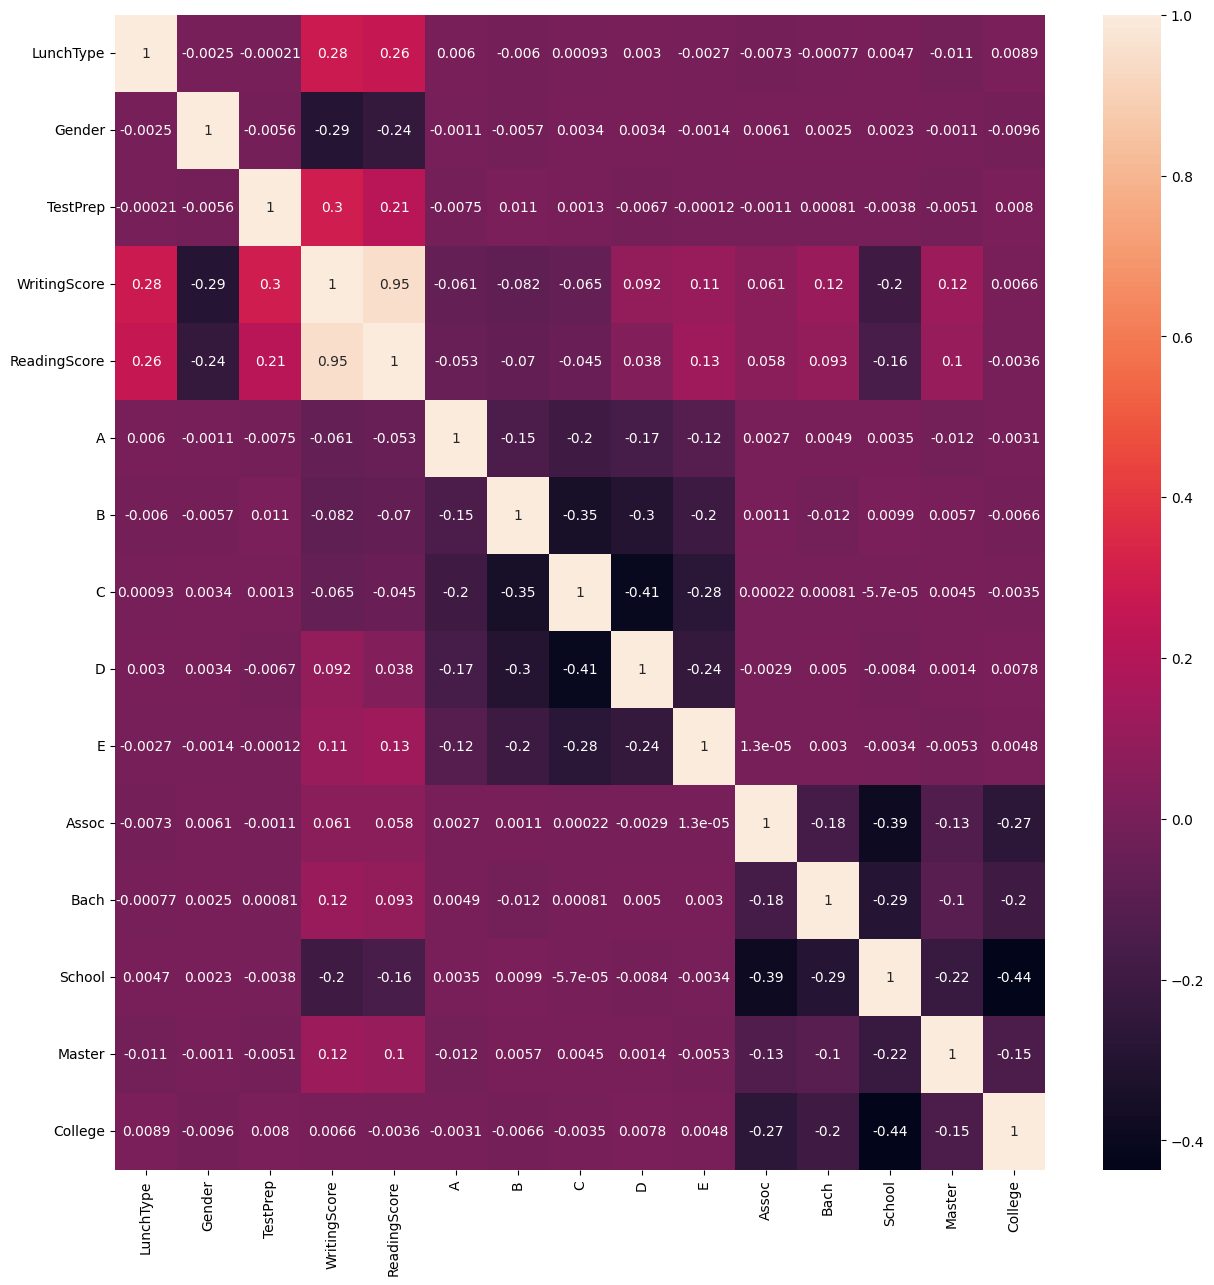

In [166]:
# Визуализация корреляционной матрицы
fig, ax = plt.subplots(1, figsize=(15, 15))
sns.heatmap(X.drop(labels='Intercept', axis=1).corr(), annot=True)

Есть интересные корреляции, например между ReadingScore и WritingScore, что полностью соответсвует логике: способность человека читать тесно связана со способностью писать

### 15. Тесты на спецификацию

RESET-тест (неробастный!) со степенями главных компонент (до 4й)

Гипотеза: $H_0:\beta_{MathScore^2}=\beta_{MathScore^3}=\beta_{MathScore^4}=0$

In [167]:
linear_reset(math_eq, power=4, test_type='princomp', use_f=True)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=9.470821257369494, p=2.993813098751235e-06, df_denom=3.06e+04, df_num=3>

In [173]:
alpha = 0.05
F_cr = stats.f.ppf(1-0.05,5,len(df)-18)
F_cr.round(2)

2.21

**Вывод: Гипотеза отвергается, регрессия не согласуется с данными**

Rainbow-test на линейность по WritingScore (выбираем половину выборки)

In [169]:
linear_rainbow(math_eq, order_by='WritingScore', frac=0.5)

(0.9594698734636508, 0.9947644268464313)

### 16. Диагностические тесты на гетероскедастичность
**Выбререм уровень значимости 1%**

Для тестрования нужна матрица наблюдений регрессоров модели. Её можно получить как `mod.model.exog`

**BP-тест** 

Модель гетероскедастичности $Var(u_i|X)=f(\gamma_0+\gamma_1x_1+\cdots+\gamma_kx_k)$

Тестируем $H_0:\begin{pmatrix} \gamma_1 & \cdots & \gamma_k \end{pmatrix}=0$ vs $H_1:\begin{pmatrix} \gamma_1 & \cdots & \gamma_k \end{pmatrix}\ne 0$

*Нулевая гипотеза*: гомоскедаастичность ошибки

*Альтернатива*: гетероскедастиность ошибки

*Промежуточная регрессия*: $e^2$ на регрессоры модели

In [176]:
BP_stat, p_val, F_stat, p_val_F = sms.het_breuschpagan(resid=math_eq.resid, exog_het=math_eq.model.exog)
BP_stat, p_val

(19.375560186607743, 0.1972169160065093)

1%-критическое значение распределения $\chi^2_{df}$

In [179]:
chi2.ppf(q=1-0.01, df=math_eq.df_model)

27.68824961045705

**Вывод**: тест указывает на гомоскедастичность (тестируемая гипотеза не отвергается) .т.к. $p\_val>\alpha$

**White-тест** (общий случай)

Тестируем $H_0:Var(u_i|X)=\sigma^2$ vs $H_1:Var(u_i|X)=\sigma^2_i$

*Нулевая гипотеза*: гомоскедаастичность ошибки

*Альтернатива*: гетероскедастиность ошибки (общего вида)

*Промежуточная регрессия*: $e^2$ на регрессоры модели, их квадраты и попарные произведения

In [180]:
test_stat, p_val, F_stat, pval_f = sms.het_white(resid=math_eq.resid, exog=math_eq.model.exog)
test_stat, p_val

(98.7590040329344, 0.08752444810983205)

**Вывод**: тест указывает на гомоскедастичность (тестируемая гипотеза не отвергается) .т.к. $p\_val>\alpha$

### 17. Робастный test

Робастные тесты не имеют смысла так как модель гомоскедастична

### 18. Вывод: 
1) Проведен анализ датасета оценок студентов с целевой пременной MathScore
2) В ходе работы достигнута хорошая тончность предсказания целевой переменной
3) Проверено множество интересных гипотез как о коэффицентах так и о модели в целом
4) Исследовано множество корреляций и зависимостей
5) Использованы различные средства визуализации для наглядного изображения результатов